In [8]:
#Imported the necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import *
from keras.utils.np_utils import to_categorical
from keras.initializers import Constant
import matplotlib.pyplot as plt
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Abido\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#Load in the data

In [12]:
#import os
#data = open(os.path.join(os.path.expanduser('~'),'A:\Abido\Documents\Airline_sentiment_tweets.csv'))

In [3]:
#First we load the airline sentiment tweets csv file in a pandas dataframe and reveal the first five data of the dataset
data = pd.read_csv(r'A:\Abido\Documents\Airline_Sentiment_tweets.csv')

data.head(5)

ParserError: Error tokenizing data. C error: Expected 1 fields in line 9, saw 2


In [4]:
#The shape attribute returns the dimensions of the NumPy array
#The order is rows and columns
data.shape

(3339, 12)

In [5]:
data.dtypes

tweet_id                         object
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
name                             object
retweet_count                   float64
text                             object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

In [6]:
#This displays the total amount of positive, neutral and negative individual tweets in the dataframe
data['airline_sentiment'].value_counts()

negative    2135
neutral      679
positive     525
Name: airline_sentiment, dtype: int64

In [8]:
#We create a new dataset called sorted_data which contains only text and airline_sentiment values in a string type and remove the neutral results
sorted_data = data[['text', 'airline_sentiment']].astype(str)
sorted_data = sorted_data[sorted_data.airline_sentiment != "neutral"]
sorted_data.head(5)

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [9]:
#The shape attribute returns the dimensions of the NumPy array
#The order is rows and columns
sorted_data.shape

(2660, 2)

In [10]:
#We convert the positive and negative texts in the airline_sentiment column to 0s and 1s for it to be processed later.
sorted_data['airline_sentiment'] = sorted_data['airline_sentiment'].replace('negative', 0)
sorted_data['airline_sentiment'] = sorted_data['airline_sentiment'].replace('positive', 1)
sorted_data.head(5)

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,1
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0
5,@VirginAmerica seriously would pay $30 a fligh...,0
6,"@VirginAmerica yes, nearly every time I fly VX...",1


In [11]:
#Graphs

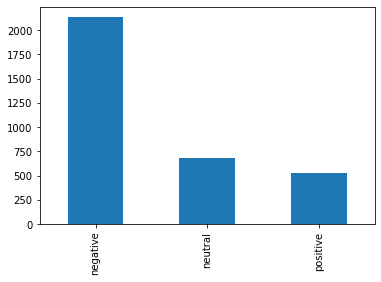

In [13]:
data['airline_sentiment'].value_counts().plot(kind='bar')

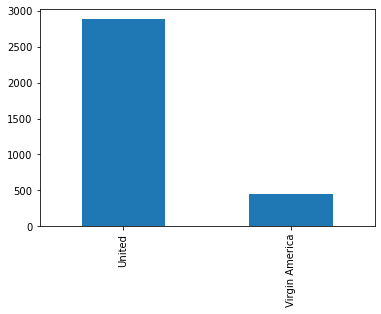

In [14]:
data['airline'].value_counts().plot(kind='bar')

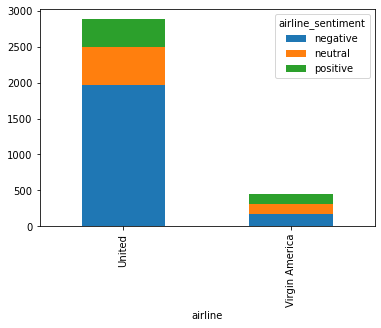

In [15]:
data.groupby(['airline', 'airline_sentiment']).size().unstack().plot(kind='bar', stacked=True)

In [14]:
#Cleaning the text

In [16]:
#Removing emojis
def remove_emoji(string):
    emoji_pattern = re.compile(
    "["
        u"\U0001F600-\U0001F64F" #emoticons
        u"\U0001F300-\U0001F5FF" #symbols & pictographs
        u"\U0001F680-\U0001F6FF" #transport & map symbols
        u"\U0001F1E0-\U0001F1FF" #FLAGS (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

In [17]:
#removing punctuation
import string

def remove_punctuation(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

In [18]:
#removing stopwords
stop = set(stopwords.words("english"))

def remove_stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    
    return " ".join(text)

In [19]:
sorted_data["text"] = sorted_data.text.map(lambda x: remove_emoji(x))
sorted_data["text"] = sorted_data.text.map(lambda x: remove_punctuation(x))
sorted_data["text"] = sorted_data["text"].map(remove_stopwords)

In [20]:
sorted_data.text

1       virginamerica plus youve added commercials exp...
3       virginamerica really aggressive blast obnoxiou...
4                      virginamerica really big bad thing
5       virginamerica seriously would pay 30 flight se...
6       virginamerica yes nearly every time fly vx “ea...
                              ...                        
3334    united idea u dont want us frustrated dont can...
3335    united patient luxurious middle seat next dela...
3336    united patient agent explains booked new fligh...
3337    united please help trace luggage put without n...
3338                                                  nan
Name: text, Length: 2660, dtype: object

In [21]:
sorted_data.head(5)

,text,airline_sentiment
1,virginamerica plus youve added commercials exp...,1
3,virginamerica really aggressive blast obnoxiou...,0
4,virginamerica really big bad thing,0
5,virginamerica seriously would pay 30 flight se...,0
6,virginamerica yes nearly every time fly vx “ea...,1


In [23]:
#splitting the data into training and testing data

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(sorted_data['text'].values, sorted_data['airline_sentiment'].values, test_size = 0.2)

In [24]:
print('text', x_train[0])
print('airline_sentiment', y_train[0])

text virginamerica ladygaga carrieunderwood julie andrews way though ladygaga impressive carrieunderwood
airline_sentiment 1


In [25]:
print('text', x_test[0])
print('airline_sentiment', y_test[0])

text united engineer designed 787 door frame extend half foot plane seat 27a forced always sit
airline_sentiment 0


In [27]:
#Hyper parameters
vocabulary_size = 10000
oov_tk = "<OOV>"
max_length = 280
trunc_type='post'
padding_type='post'

In [29]:
#Tokenizing
tokenizer = Tokenizer(num_words = vocabulary_size, oov_token = oov_tk) #num_words = maximum number of words to keep. We keep only 10000 words
#OOV means out of vocabulary. youll need a big word index to handle sentences that are not in the training corpus. but to not lose the length of sentence yo use = the tokenizer will create a token for that and then replace words it doesn not recongise witht he oov instead
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index #word index is a dictonary showing you the key being the word and the value being the token for that word. 
print(word_index)

{'<OOV>': 1, 'united': 2, 'flight': 3, 'virginamerica': 4, 'get': 5, 'service': 6, 'thanks': 7, 'customer': 8, 'time': 9, 'cancelled': 10, 'im': 11, 'delayed': 12, 'bag': 13, 'thank': 14, 'plane': 15, 'would': 16, 'help': 17, 'hours': 18, 'amp': 19, 'us': 20, 'gate': 21, 'flights': 22, 'one': 23, 'airline': 24, 'still': 25, 'like': 26, 'cant': 27, 'late': 28, 'hour': 29, '2': 30, 'dont': 31, 'back': 32, 'waiting': 33, 'flightled': 34, 'lost': 35, 'got': 36, '3': 37, 'ever': 38, 'delay': 39, 'really': 40, 'luggage': 41, 'never': 42, 'great': 43, 'worst': 44, 'crew': 45, 'trying': 46, 'please': 47, 'people': 48, 'fly': 49, 'airport': 50, 'need': 51, 'agent': 52, 'day': 53, 'way': 54, 'check': 55, 'staff': 56, 'last': 57, 'bags': 58, 'seat': 59, 'wait': 60, 'good': 61, 'due': 62, 'u': 63, 'going': 64, 'flying': 65, 'go': 66, 'home': 67, 'first': 68, 'today': 69, 'even': 70, 'yes': 71, 'baggage': 72, 'know': 73, 'seats': 74, 'experience': 75, '4': 76, 'dm': 77, 'ticket': 78, 'told': 79, 'g

In [30]:
#Sequences
#Fitting the train and test into a sequences
#This creates sequences of tokens representing each sentence
train_sequences = tokenizer.texts_to_sequences(x_train) 
test_sequences = tokenizer.texts_to_sequences(x_test)

print("Train Sequences = " ,train_sequences)
print("-------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------")
print("Test Sequences = " ,test_sequences)

Train Sequences =  [[4, 1292, 1293, 1931, 1932, 54, 225, 1292, 1933, 1293], [2, 467, 45, 468, 1934, 1294, 1935, 1295, 1936, 1937, 132], [2, 270, 217, 806, 1938, 48, 284, 23, 127, 469, 270, 339, 1939], [2, 16, 43, 270, 1940], [2, 133, 1941, 2, 3, 7, 225, 978, 88, 423], [2, 1296, 128, 9, 979, 285, 673, 1942, 980, 218, 189, 19], [2, 603, 13, 173, 205, 61, 1943, 102, 981, 604, 17], [2, 16, 5, 177, 340, 1297, 674, 66, 1298, 16, 25, 146, 117], [2, 61, 3, 14], [2, 134, 236, 1944, 1945, 3, 134, 81, 111, 103, 1299, 341, 111, 470, 471], [2, 271, 1300, 122, 206, 309, 1301, 605, 606, 161, 309, 134, 178, 1946, 190, 9], [4, 272, 26, 219, 472, 1302, 1947], [2, 7, 807, 3, 29, 112, 20, 982, 3, 1303, 1304, 362, 1305, 808], [4, 220, 207, 29, 28, 3, 13, 55, 147, 139, 424, 1948], [2, 16, 342, 13, 809, 983, 984, 1306, 286, 473, 27, 253], [2, 7, 1949, 11, 363, 810, 985, 254, 56, 986, 191, 1950], [2, 102, 1951, 1952, 287], [2, 71, 343, 1953, 57, 179, 533, 192, 72, 148, 8, 6, 675, 208, 533, 23, 226, 78, 52], [

In [31]:
#Testing the test sequences to see if it works
test_data = ['i do like flying right now',
           'united are sucks so bad why do you exist ']

example_test_seq = tokenizer.texts_to_sequences(test_data)
print(example_test_seq)

[[1, 1, 26, 65, 200, 1], [2, 1, 355, 1, 223, 1, 1, 1, 3800]]


In [35]:
#Padding
#To handle sentences with different lengths. You use raggerd tensor -> advanced. we use padding for simple people like us
padded_train = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
padded_test = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print("Train Padded = " ,padded_train)
print("-------------------------------------------------------------------------------------------------------------------")
print("-------------------------------------------------------------------------------------------------------------------")
print("Test Padded = " ,padded_test)

Train Padded =  [[   4 1292 1293 ...    0    0    0]
 [   2  467   45 ...    0    0    0]
 [   2  270  217 ...    0    0    0]
 ...
 [   2 1000  976 ...    0    0    0]
 [   2  354   85 ...    0    0    0]
 [   2   64   37 ...    0    0    0]]
-------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------
Test Padded =  [[  2   1   1 ...   0   0   0]
 [  2   7 267 ...   0   0   0]
 [  4  35  41 ...   0   0   0]
 ...
 [  2 759 329 ...   0   0   0]
 [  2 707   0 ...   0   0   0]
 [  2   7 978 ...   0   0   0]]


In [36]:
vocabulary_size =len(word_index) #V
print('The size of the airline dataset vocabulary is: ', vocabulary_size)

The size of the airline dataset vocabulary is:  4925


In [37]:
training_sequence = padded_train.shape[1] #T

print('The length of training sequence is: ', training_sequence)

The length of training sequence is:  280


In [38]:
print('The length of testing sequence is: ', padded_test.shape[1])

The length of testing sequence is:  280


In [32]:
#Pre-trained Glove word embedding

In [39]:
#Loading the file
embedding_dict= {}
with open(r'A:\Abido\Documents\Glove\glove.6B.100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_dict[word] = coefs
    f.close()

print('Found %s word vectors.' % len(embedding_dict))

Found 400000 word vectors.


In [40]:
#unique values
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 4925 unique tokens.


In [41]:
embedding_dict

{'the': array([-0.038194, -0.24487 ,  0.72812 , -0.39961 ,  0.083172,  0.043953,
        -0.39141 ,  0.3344  , -0.57545 ,  0.087459,  0.28787 , -0.06731 ,
         0.30906 , -0.26384 , -0.13231 , -0.20757 ,  0.33395 , -0.33848 ,
        -0.31743 , -0.48336 ,  0.1464  , -0.37304 ,  0.34577 ,  0.052041,
         0.44946 , -0.46971 ,  0.02628 , -0.54155 , -0.15518 , -0.14107 ,
        -0.039722,  0.28277 ,  0.14393 ,  0.23464 , -0.31021 ,  0.086173,
         0.20397 ,  0.52624 ,  0.17164 , -0.082378, -0.71787 , -0.41531 ,
         0.20335 , -0.12763 ,  0.41367 ,  0.55187 ,  0.57908 , -0.33477 ,
        -0.36559 , -0.54857 , -0.062892,  0.26584 ,  0.30205 ,  0.99775 ,
        -0.80481 , -3.0243  ,  0.01254 , -0.36942 ,  2.2167  ,  0.72201 ,
        -0.24978 ,  0.92136 ,  0.034514,  0.46745 ,  1.1079  , -0.19358 ,
        -0.074575,  0.23353 , -0.052062, -0.22044 ,  0.057162, -0.15806 ,
        -0.30798 , -0.41625 ,  0.37972 ,  0.15006 , -0.53212 , -0.2055  ,
        -1.2526  ,  0.071624,  

In [42]:
#Creating the embedding matrix
num_words = len(word_index) + 1
embedding_dimension = 100
embedding_matrix = np.zeros((num_words, embedding_dimension))

for word, i in word_index.items():
    if i < num_words:
        embedding_vector = embedding_dict.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [37]:
embedding_matrix

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.21732999,  0.56116003,  0.63062   , ...,  0.0098267 ,
         0.39708   , -0.34707999],
       ...,
       [-0.027259  ,  0.51779997,  0.14915   , ..., -0.1132    ,
        -0.093224  , -0.41901001],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [43]:
word_index["good"]

61

In [44]:
embedding_dict.get("good")

array([-0.030769 ,  0.11993  ,  0.53909  , -0.43696  , -0.73937  ,
       -0.15345  ,  0.081126 , -0.38559  , -0.68797  , -0.41632  ,
       -0.13183  , -0.24922  ,  0.441    ,  0.085919 ,  0.20871  ,
       -0.063582 ,  0.062228 , -0.051234 , -0.13398  ,  1.1418   ,
        0.036526 ,  0.49029  , -0.24567  , -0.412    ,  0.12349  ,
        0.41336  , -0.48397  , -0.54243  , -0.27787  , -0.26015  ,
       -0.38485  ,  0.78656  ,  0.1023   , -0.20712  ,  0.40751  ,
        0.32026  , -0.51052  ,  0.48362  , -0.0099498, -0.38685  ,
        0.034975 , -0.167    ,  0.4237   , -0.54164  , -0.30323  ,
       -0.36983  ,  0.082836 , -0.52538  , -0.064531 , -1.398    ,
       -0.14873  , -0.35327  , -0.1118   ,  1.0912   ,  0.095864 ,
       -2.8129   ,  0.45238  ,  0.46213  ,  1.6012   , -0.20837  ,
       -0.27377  ,  0.71197  , -1.0754   , -0.046974 ,  0.67479  ,
       -0.065839 ,  0.75824  ,  0.39405  ,  0.15507  , -0.64719  ,
        0.32796  , -0.031748 ,  0.52899  , -0.43886  ,  0.6740

In [45]:
(embedding_matrix[61] == embedding_dict.get("good")).all()

True

In [46]:
print(padded_train.shape)
print(y_train.shape)

(2128, 280)
(2128,)


In [47]:
print(padded_test.shape)
print(y_test.shape)

(532, 280)
(532,)


In [43]:
#Training the Model

In [48]:
#BI-LSTM model
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

BI_LSTM_model= Sequential()

BI_LSTM_model.add(Embedding(num_words, 
                          embedding_dimension, 
                          embeddings_initializer=Constant(embedding_matrix),
                           input_length=max_length,
                           trainable=False))

BI_LSTM_model.add(SpatialDropout1D(0.2))
BI_LSTM_model.add(Bidirectional(LSTM(64, return_sequences=True)))
BI_LSTM_model.add(Bidirectional(LSTM(32)))
BI_LSTM_model.add(Dropout(0.25))
BI_LSTM_model.add(Dense(units=32, activation = 'relu'))
BI_LSTM_model.add(Dense(units=1, activation='sigmoid'))

BI_LSTM_model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(BI_LSTM_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 100)          492600    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 280, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 280, 128)          84480     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [49]:
#Training stage
#Recommended 100 epochs.
#Batch Size 256
number_of_epochs = 10
#batch_size = 512

BI_LSTM_history = BI_LSTM_model.fit(padded_train, y_train, 
                                    epochs = number_of_epochs,
                                   # batch_size=batch_size,
                   validation_data=(padded_test, y_test), 
                                    verbose=1)

Epoch 1/10
67/67 [==============================] - 18s 263ms/step - loss: 0.4493 - accuracy: 0.8003 - val_loss: 0.2979 - val_accuracy: 0.9004
Epoch 2/10
67/67 [==============================] - 15s 231ms/step - loss: 0.3216 - accuracy: 0.8684 - val_loss: 0.2726 - val_accuracy: 0.9060
Epoch 3/10
67/67 [==============================] - 16s 240ms/step - loss: 0.2834 - accuracy: 0.8905 - val_loss: 0.2588 - val_accuracy: 0.9041
Epoch 4/10
67/67 [==============================] - 16s 246ms/step - loss: 0.2667 - accuracy: 0.8900 - val_loss: 0.2616 - val_accuracy: 0.9023
Epoch 5/10
67/67 [==============================] - 16s 240ms/step - loss: 0.2483 - accuracy: 0.9037 - val_loss: 0.2587 - val_accuracy: 0.8947
Epoch 6/10
67/67 [==============================] - 16s 233ms/step - loss: 0.2356 - accuracy: 0.9093 - val_loss: 0.2579 - val_accuracy: 0.8966
Epoch 7/10
67/67 [==============================] - 16s 236ms/step - loss: 0.2248 - accuracy: 0.9131 - val_loss: 0.2767 - val_accuracy: 0.8797

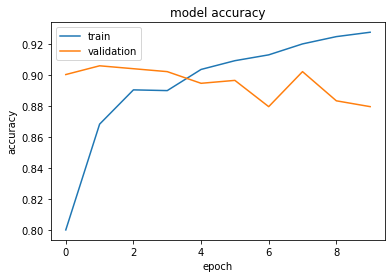

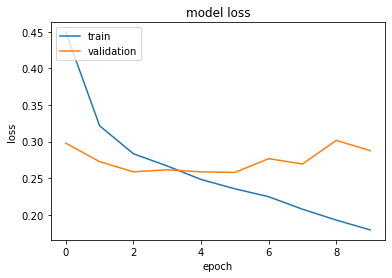

In [50]:
#Plotting the BI-LSTM train Graph

plt.plot(BI_LSTM_history.history['accuracy'])
plt.plot(BI_LSTM_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(BI_LSTM_history.history['loss'])
plt.plot(BI_LSTM_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [47]:
#Testing the BI-LSTM Model

In [51]:
#testing using the basic test function

new_test_sentence = [
                "The flight amazing and fun. i will fly again",
                "The service was horrible and it did not provide me",
                "I am quite enjoyed the flight :) but the food could be improved!"]

# Converting the sentences to sequences using tokenizer
new_test_sequences = tokenizer.texts_to_sequences(new_test_sentence)
# padding the new sequences to make them have same dimensions
new_test_padded = pad_sequences(new_test_sequences, maxlen = max_length,
                           padding = padding_type,
                           truncating = trunc_type)

new_test_padded = np.array(new_test_padded)

print(BI_LSTM_model.predict(new_test_padded))

[[0.9809798 ]
 [0.02207196]
 [0.88009894]]


In [44]:
#BI-GRU model
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from keras.initializers import Constant
from keras.optimizers import Adam

BI_GRU_model= Sequential()

BI_GRU_model.add(Embedding(num_words, 
                          embedding_dimension, 
                          embeddings_initializer=Constant(embedding_matrix),
                           input_length=max_length,
                           trainable=False))

BI_GRU_model.add(SpatialDropout1D(0.2))
BI_GRU_model.add(Bidirectional(GRU(64, return_sequences=True)))
BI_GRU_model.add(Bidirectional(GRU(32)))
BI_GRU_model.add(Dropout(0.25))
BI_GRU_model.add(Dense(units=32, activation = 'relu'))
BI_GRU_model.add(Dense(units=1, activation='sigmoid'))

BI_GRU_model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(BI_GRU_model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 280, 100)          490300    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 280, 100)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 280, 128)          63744     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                31104     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 3

In [45]:
#Training stage
#Recommended 100 epochs.
#Batch Size 256
number_of_epochs = 100
#batch_size = 256

BI_GRU_history = BI_GRU_model.fit(padded_train, y_train, 
                                    epochs = number_of_epochs,
                                    #batch_size=batch_size,
                   validation_data=(padded_test, y_test), 
                                    verbose=1)

Epoch 1/100
67/67 [==============================] - 18s 261ms/step - loss: 0.4216 - accuracy: 0.8200 - val_loss: 0.2744 - val_accuracy: 0.9098
Epoch 2/100
67/67 [==============================] - 16s 235ms/step - loss: 0.3039 - accuracy: 0.8820 - val_loss: 0.2603 - val_accuracy: 0.9023
Epoch 3/100
67/67 [==============================] - 16s 233ms/step - loss: 0.2616 - accuracy: 0.8985 - val_loss: 0.2566 - val_accuracy: 0.9004
Epoch 4/100
67/67 [==============================] - 15s 230ms/step - loss: 0.2549 - accuracy: 0.9060 - val_loss: 0.2514 - val_accuracy: 0.9135
Epoch 5/100
67/67 [==============================] - 15s 222ms/step - loss: 0.2329 - accuracy: 0.9098 - val_loss: 0.2557 - val_accuracy: 0.8966
Epoch 6/100
67/67 [==============================] - 14s 214ms/step - loss: 0.2227 - accuracy: 0.9117 - val_loss: 0.2551 - val_accuracy: 0.9004
Epoch 7/100
67/67 [==============================] - 14s 210ms/step - loss: 0.2097 - accuracy: 0.9215 - val_loss: 0.2569 - val_accuracy:

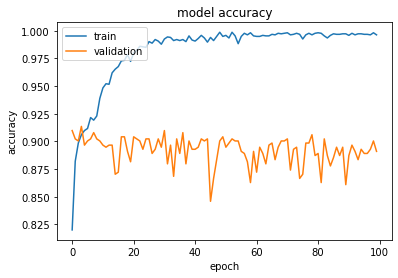

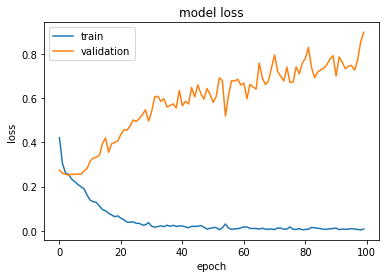

In [46]:
#Plotting the BI-GRU train Graph

plt.plot(BI_GRU_history.history['accuracy'])
plt.plot(BI_GRU_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(BI_GRU_history.history['loss'])
plt.plot(BI_GRU_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#Testing the BI-GRU Model

In [47]:
#testing using the basic test function

new_test_sentence = [
                "The flight amazing and fun. i will fly again. it was exquisite ",
                "The service was horrible and i did not like the atmosphere at all"]

# Converting the sentences to sequences using tokenizer
new_test_sequences = tokenizer.texts_to_sequences(new_test_sentence)
# padding the new sequences to make them have same dimensions
new_test_padded = pad_sequences(new_test_sequences, maxlen = max_length,
                           padding = padding_type,
                           truncating = trunc_type)

new_test_padded = np.array(new_test_padded)
print(BI_GRU_model.predict(new_test_padded))

[[9.9999893e-01]
 [1.2437581e-06]]


In [ ]:
#Testing on a airline sentiment dataset

In [52]:
#Prediction 

y_prediction = BI_LSTM_model.predict(padded_test)
#y_prediction = BI_GRU_model.predict(padded_test)

In [53]:
#Accuracy testing
from sklearn.metrics import confusion_matrix, accuracy_score

accuracy_score(list(map(lambda x: np.argmax(x), y_test)), list(map(lambda x: np.argmax(x), y_prediction)))

1.0

In [54]:
#loading in the same airline dataset
df_test = pd.read_csv(r'A:\Abido\Documents\Airline_sentiment_tweets.csv')

df_test['test_text'] = df_test['text'].astype(str)
df_test = df_test[df_test.airline_sentiment != "neutral"]

In [55]:
#cleaning the tesxt
df_test["test_text"] = df_test.test_text.map(lambda x: remove_emoji(x))
df_test["test_text"] = df_test.test_text.map(lambda x: remove_punctuation(x))
df_test["test_text"] = df_test["test_text"].map(remove_stopwords)

In [56]:
df_test.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,name,retweet_count,text,tweet_created,tweet_location,user_timezone,test_text
1,Tr_tweet_2,positive,0.3486,NaN,0.0000,Virgin America,jnardino,0.0,@VirginAmerica plus you've added commercials t...,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),virginamerica plus youve added commercials exp...
3,Tr_tweet_4,negative,1.0000,Bad Flight,0.7033,Virgin America,jnardino,0.0,@VirginAmerica it's really aggressive to blast...,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),virginamerica really aggressive blast obnoxiou...
4,Tr_tweet_5,negative,1.0000,Can't Tell,1.0000,Virgin America,jnardino,0.0,@VirginAmerica and it's a really big bad thing...,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),virginamerica really big bad thing
5,Tr_tweet_6,negative,1.0000,Can't Tell,0.6842,Virgin America,jnardino,0.0,@VirginAmerica seriously would pay $30 a fligh...,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),virginamerica seriously would pay 30 flight se...
6,Tr_tweet_7,positive,0.6745,NaN,0.0000,Virgin America,cjmcginnis,0.0,"@VirginAmerica yes, nearly every time I fly VX...",2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),virginamerica yes nearly every time fly vx “ea...


In [57]:
#tokenizing and padding it
x = tokenizer.texts_to_sequences(df_test['test_text'].values)
x = pad_sequences(x, max_length)

y_predict = BI_LSTM_model.predict(x)
#y_predict = BI_GRU_model.predict(x)


y_prediction=np.round(y_predict)

print(y_predict)

[[0.7121065]
 [0.7315239]
 [0.7042896]
 ...
 [0.759672 ]
 [0.7816913]
 [0.7235632]]


In [58]:
#Only displaying negative :/
#Oh well.

df_results = pd.DataFrame(list(zip(df_test['test_text'].values, list(map(lambda
x: np.argmax(x), y_predict)))), columns=['test_text', 'sentiment_result'])

In [59]:
df_results.head(5)


,test_text,sentiment_result
0,virginamerica plus youve added commercials exp...,0
1,virginamerica really aggressive blast obnoxiou...,0
2,virginamerica really big bad thing,0
3,virginamerica seriously would pay 30 flight se...,0
4,virginamerica yes nearly every time fly vx “ea...,0


In [60]:
sorted_data.head(100)

,text,airline_sentiment
1,virginamerica plus youve added commercials exp...,1
3,virginamerica really aggressive blast obnoxiou...,0
4,virginamerica really big bad thing,0
5,virginamerica seriously would pay 30 flight se...,0
6,virginamerica yes nearly every time fly vx “ea...,1
...,...,...
139,virginamerica thank checking tickets purchased...,1
143,virginamerica problems flight booking problems...,0
144,virginamerica reschedule cancelled flightled f...,0
145,virginamerica rang wait 35 minutes book ticket...,0


In [ ]:
df_results.to_csv('Sentiment_analysis_BILSTM_results.csv', index=False)

In [ ]:
#https://www.kaggle.com/hamishdickson/bidirectional-lstm-in-keras-with-glove-embeddings